**Домашнее задание к лекции "Статистика. Практика"**

**Задание 1**\
Вернемся к набору данных о видеоиграх.

Ответьте на следующие вопросы:

Как критики относятся к спортивным играм?\
Критикам нравятся больше игры на PC или на PS4?\
Критикам больше нравятся стрелялки или стратегии?\
Для каждого вопроса:

сформулируйте нулевую и альтернативную гипотезы;\
выберите пороговый уровень статистической значимости;\
опишите полученные результаты статистического теста.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu

In [2]:
vg = pd.read_csv('https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/vgsales.csv')
vg.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
vg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


**Как критики относятся к спортивным играм?**\
Для начала построим график оценок критиков спортивных игр.
Посмотрим, насколько эти оценки отличаются.
Затем посчитаем среднюю оценку. Сравним эту оценку со средним показателем по остальным жанрам.

Для начала создадим таблицу с данными, по которым есть оценка критиков

In [4]:
vg_critic = vg.dropna(subset = ['Critic_Score'])
vg_critic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8137 entries, 0 to 16709
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             8137 non-null   object 
 1   Platform         8137 non-null   object 
 2   Year_of_Release  7983 non-null   float64
 3   Genre            8137 non-null   object 
 4   Publisher        8133 non-null   object 
 5   NA_Sales         8137 non-null   float64
 6   EU_Sales         8137 non-null   float64
 7   JP_Sales         8137 non-null   float64
 8   Other_Sales      8137 non-null   float64
 9   Global_Sales     8137 non-null   float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       8099 non-null   object 
 13  User_Count       7017 non-null   float64
 14  Developer        8131 non-null   object 
 15  Rating           8054 non-null   object 
dtypes: float64(9), object(7)
memory usage: 1.1+ MB


Построим график оценок по жанру Sports:

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,7

Text(0.5, 1.0, 'Распределение оценок критиков жанра sport')

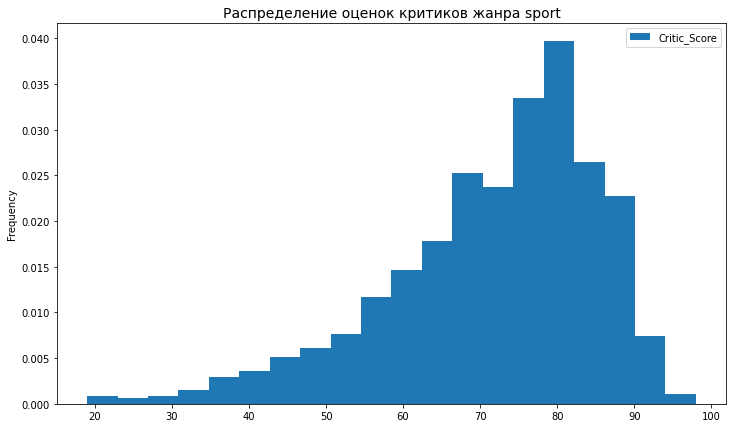

In [32]:
vg_critic[vg_critic['Genre']== 'Sports']['Critic_Score'].plot(kind='hist',bins=20, 
                                  density = True,legend = True)

plt.title('Распределение оценок критиков жанра sport', fontsize = 14)

Поскольку гистограмма смещена влево, можно предположить, что критики положительно оценивают этот жанр.

Построим график средних оценок по всем жанрам:

Text(0.5, 1.0, 'Распределение оценок критиков по жанрам')

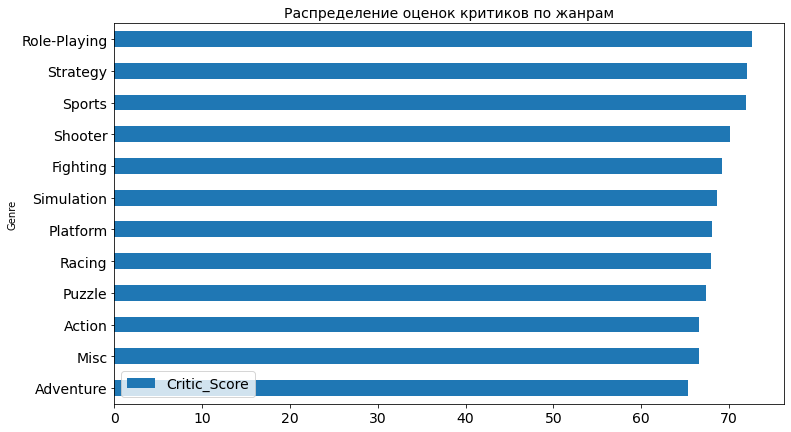

In [31]:
vg_critic[['Critic_Score', 'Genre']].groupby('Genre').mean().sort_values('Critic_Score').\
                            plot(kind='barh', fontsize = 14)
plt.legend(loc = 'lower left', fontsize = 14)
plt.title('Распределение оценок критиков по жанрам', fontsize = 14)

Спортивные игры находятся на 3-ем месте согласно графику по оценкам критиков. Критики относятся к этому жанру лучше, чем ко многим. Проверим, насколько эти различия статистически значимы.

Напишем функции проверки распределений на нормальность и на одинаковость дисперсий.

In [9]:
def normal_dist(list_data):
    """ Функция проверяет распредление данных на нормальность
    с помощью теста Шапиро-Уилка
    """
    result = []
    for data in list_data:       
        stat, p = stats.shapiro(data)

        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            result.append('Нормальное')
        else:
            result.append('Ненормальное')
    
    return result

In [10]:
def f_test(group1, group2):
    """Функция проверяет выборки на разность дисперсий
    с помощью f-теста
    """
    x = np.array(group1)
    y = np.array(group2)
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = x.size-1
    dun = y.size-1
    p_value = 1-stats.f.cdf(f, nun, dun)
    if p_value > 0.05:
        return 'Вариация вероятно одинаковая'
    else:
        return 'Вариация разная'

В качестве выборок возьмем оценки по жанру Sports и по тем жанру, который был хуже оценен критиками.

In [11]:
sports = vg_critic[vg_critic['Genre']=='Sports']['Critic_Score']
shooter = vg_critic[vg_critic['Genre'] == 'Shooter']['Critic_Score']

In [12]:
normal_dist([sports, shooter])

stat=0.940, p=0.000
stat=0.957, p=0.000


['Ненормальное', 'Ненормальное']

Поскольку распределения ненормальные, воспользуемся тестом Манна-Уитни для оценки значимости различий.

In [ ]:
stat, p = stats.mannwhitneyu(sports, shooter)

print('Статистика = %.3f, p = %.9f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика = 606181.000, p = 0.002636306
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


Согласно тесту Манна-Уитни На уровне значимости 0, 05 критикам вероятно больше нравятся спортивные игры, чем шутеры.

Попробуем применить тест Краскела-Уоллиса

In [34]:
stat, p = stats.kruskal(sports, shooter)

print('Статистика=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=9.044, p=0.003
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


Результат схожий. Согласно тесту Краскела-Уоллиса На уровне значимости 0, 05 критикам вероятно больше нравятся спортивные игры, чем шутеры.

Сравним визуально:

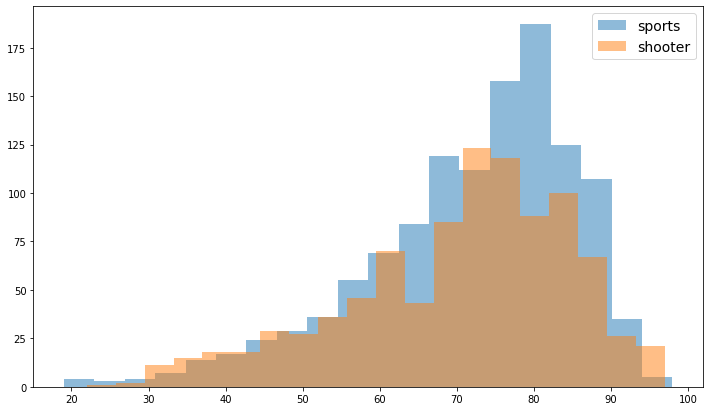

In [33]:
plt.hist(sports, bins=20, alpha = 0.5); 
plt.hist(shooter, bins=20, alpha = 0.5);  
plt.legend(['sports', 'shooter'], fontsize = 14)

Теперь проверим, являются ли значимыми различия с жанрами, которые, согласно графику, больше нравятся критикам.

In [17]:
strategy = vg_critic[vg_critic['Genre'] == 'Strategy']['Critic_Score']
role = vg_critic[vg_critic['Genre'] == 'Role-Playing']['Critic_Score']

In [18]:
stat, p = stats.mannwhitneyu(sports, strategy)

print('Статистика = %.3f, p = %.9f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика = 186990.000, p = 0.317969741
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


Различия между спортивными играми и стратегиями не значимы. Вероятно критики относятся к этим жанрам почти одинаково.

In [19]:
stat, p = stats.mannwhitneyu(sports, role)

print('Статистика = %.3f, p = %.9f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика = 443688.500, p = 0.755900360
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


Сравнение с ролевыми играми также не показало значимых различий согласно U-тесту Манна-Уитни. В этом случае мы можем предположить, что спортивные игры наравне с шутерами и ролевыми играми являются лидерами по оценкам критиков.

**Критикам нравятся больше игры на PC или на PS4?**\
Cравним визуально оценки критиков двух платформ, потом проверим статистически, есть ли различия

In [20]:
PC = vg_critic[vg_critic['Platform']=='PC']['Critic_Score']
PS4 = vg_critic[vg_critic['Platform']=='PS4']['Critic_Score']

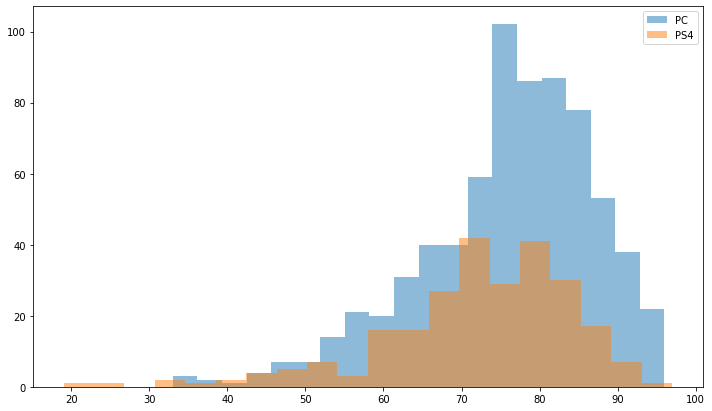

In [21]:
plt.hist(PC, bins=20, alpha = 0.5); 
plt.hist(PS4, bins=20, alpha = 0.5);  
plt.legend(['PC', 'PS4'])

Визуально кажется, что критикам больше нравится плтформа PC

In [35]:
vg_critic['Platform'].value_counts()

PS2     1298
X360     916
PS3      820
XB       725
DS       717
PC       715
Wii      585
PSP      462
GC       448
GBA      438
PS4      252
PS       200
XOne     169
3DS      168
PSV      120
WiiU      90
DC        14
Name: Platform, dtype: int64

При этом игр на платформе PC почти в 3 раза больше, чем на платформе PS4. Не понятно, насколько верно сравнивать настолько разноразмерные выборки.

In [22]:
normal_dist([PC, PS4])

stat=0.957, p=0.000
stat=0.933, p=0.000


['Ненормальное', 'Ненормальное']

In [23]:
stat, p = stats.mannwhitneyu(PC, PS4)

print('Статистика = %.3f, p = %.9f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика = 106906.500, p = 0.000010201
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


Статистически эти различия тоже значимы.

**Критикам больше нравятся стрелялки или стратегии?**

In [24]:
stat, p = stats.mannwhitneyu(shooter, strategy)

print('Статистика = %.3f, p = %.9f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика = 136251.500, p = 0.247539621
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


Согласно U-тесту, вероятно критики относятся к этим жанрам почти одинаково.

**Задание 2**\
Реализуйте базовую модель логистической регрессии для классификации текстовых сообщений (используемые данные здесь) по признаку спама.\
Для этого:

Привидите весь текст к нижнему регистру;\
Удалите мусорные символы;\
Удалите стоп-слова;\
Привидите все слова к нормальной форме;\
Преобразуйте все сообщения в вектора TF-IDF. Вам поможет следующий код:\

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()\
tfidf_matrix = tfidf.fit_transform(df.Message)\
names = tfidf.get_feature_names()\
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)\

Можете поэкспериментировать с параметрами TfidfVectorizer;\

6) Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите random_state=42. Используйте train_test_split;\
7) Постройте модель логистической регрессии, укажите random_state=42, оцените ее точность на тестовых данных;\
8) Опишите результаты при помощи confusion_matrix;\
9) Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).

In [2]:
import glob
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
spam = pd.read_csv('https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/spam.csv')
spam.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [62]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Приводим к нижнему регистру

In [4]:
def low(param): 
    return param.lower()
  
spam['mes_for_model'] = spam['Message'].apply(low)

Проверяем

In [5]:
spam.head()

,Category,Message,mes_for_model
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."


Убираем служебные символы

In [6]:
def clean(param):
    return re.sub('[\W_]+', ' ', param)

spam['mes_for_model'] = spam['mes_for_model'].apply(clean)

In [7]:
spam.head()

,Category,Message,mes_for_model
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


Удаляем стоп слова

In [8]:
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def without_sw(param):
    param = param.split()
    wsw = []
    for word in param:
        if word not in stopwords_set:
            wsw.append(word)
    
    return ' '.join(wsw)

In [10]:
spam['mes_for_model'] = spam['mes_for_model'].apply(without_sw)

In [11]:
spam.head()

,Category,Message,mes_for_model
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though


Приводим слова к нормальной форме:

In [12]:
nltk.download('omw-1.4')
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(param):
    lemmas = [wordnet_lemmatizer.lemmatize(word) for word in param.split()]
    return ' '.join(lemmas)


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
spam['mes_for_model'] = spam['mes_for_model'].apply(lemmatizer)

In [14]:
spam.head()

,Category,Message,mes_for_model
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


Преобразовываем все сообщения в вектора TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 0.001, max_df = 0.1)
tfidf_matrix = tfidf.fit_transform(spam['mes_for_model'])
names = tfidf.get_feature_names_out()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)
tfidf_matrix

,00,000,02,03,04,06,0800,08000839402,08000930705,0870,...,yes,yest,yesterday,yet,yijue,yo,yoga,yr,yup,zed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category       5572 non-null   object
 1   Message        5572 non-null   object
 2   mes_for_model  5572 non-null   object
dtypes: object(3)
memory usage: 130.7+ KB


Посмотрим, как распределены данные в зависимой переменной:

In [17]:
spam['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

Поскольку данные распределены неравномерно, нам надо проконтролировать, чтобы тестовые и тренировочные значения были сбалансированы. Предположим, что пропорция значений в зависимой переменной соответствует реальной картине и нет надобности сэмплировать данные.

**Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите random_state=42. Используйте train_test_split;**

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, spam['Category'], shuffle = True ,stratify = spam['Category'], test_size = 0.3, random_state = 42)

Импортируем класс логистической регрессии

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
model = LogisticRegression(random_state = 42)

In [21]:
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

Тестируем

In [22]:
predicted_y = model.predict(X_test)
predicted_y

array(['spam', 'ham', 'spam', ..., 'spam', 'ham', 'ham'], dtype=object)

Сравниваем значения

In [24]:
df_compare = pd.DataFrame ([y_test.values, predicted_y]).T
df_compare.columns = ['class', 'target']
df_compare

,class,target
0,spam,spam
1,ham,ham
2,spam,spam
3,ham,ham
4,ham,ham
...,...,...
1667,ham,ham
1668,ham,ham
1669,spam,spam
1670,ham,ham


**Опишите результаты при помощи confusion_matrix;**

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
confusion_matrix(y_test.values, predicted_y)

array([[1448,    0],
       [  57,  167]])

Процент ложно положительных результатов (сообщение является спамом, но не идентифицированно как спам) достаточно мал, но больше, чем процент ложно отрицательных (0). В случае с определением спама, это лучше, чем если бы было наоборот.

In [27]:
from sklearn.metrics import classification_report

In [28]:
report = classification_report(y_test, model.predict(X_test), target_names=['ham', 'spam'])
print(report)

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1448
        spam       1.00      0.75      0.85       224

    accuracy                           0.97      1672
   macro avg       0.98      0.87      0.92      1672
weighted avg       0.97      0.97      0.96      1672



Точность обоих классов сообщений достаточно высокая, а полнота выше (идеальная) у обычных сообщений, чем у спама.

**Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).**

In [30]:
df_compare['texts'] = spam['Message']
df_compare_mistakes = df_compare[((df_compare['class'] == 'spam') & (df_compare['target'] == 'ham')) | ((df_compare['class'] == 'ham') & (df_compare['target'] == 'spam'))]
df_compare_mistakes

,class,target,texts
38,spam,ham,Anything lor... U decide...
49,spam,ham,U don't know how stubborn I am. I didn't even ...
64,spam,ham,Ok lar i double check wif da hair dresser alre...
75,spam,ham,I am waiting machan. Call me once you free.
86,spam,ham,For real when u getting on yo? I only need 2 m...
96,spam,ham,Watching telugu movie..wat abt u?
99,spam,ham,I see a cup of coffee animation
102,spam,ham,I'm still looking for a car to buy. And have n...
141,spam,ham,"K, text me when you're on the way"
147,spam,ham,FreeMsg Why haven't you replied to my text? I'...
